## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Building the RNN
from keras.models import Sequential # Sequential Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout #to avoid overfitting


Using TensorFlow backend.


## Read data

In [2]:
dataset_train= pd.read_csv('GoogleStocks.csv')
dataset_train = dataset_train.iloc[1:]

In [3]:
len(dataset_train)

755

In [4]:
dataset_train.head()

,date,close,volume,open,high,low
1,2019/03/26,1184.6200,1894639.0000,1198.5300,1202.8300,1176.7200
2,2019/03/25,1193.0000,1493841.0000,1196.9300,1206.3975,1187.0400
3,2019/03/22,1205.5000,1668910.0000,1226.3200,1230.0000,1202.8250
4,2019/03/21,1231.5400,1195899.0000,1216.0000,1231.7900,1213.1500
5,2019/03/20,1223.9700,2089367.0000,1197.3500,1227.1400,1196.1700


In [5]:
# sort data by date old to recent
dataset_train = dataset_train.sort_values('date')
dataset_train.head()

,date,close,volume,open,high,low
755,2016/03/28,733.5300,1300817.0000,736.7900,738.9900,732.5000
754,2016/03/29,744.7700,1902254.0000,734.5900,747.2500,728.7600
753,2016/03/30,750.5300,1782278.0000,750.1000,757.8800,748.7400
752,2016/03/31,744.9500,1718638.0000,749.2500,750.8500,740.9400
751,2016/04/01,749.9100,1576240.0000,738.6000,750.3400,737.0000


### Convert columns from string values to float values

In [6]:
#open col from string values to float values
dataset_train['open'] = dataset_train['open'].astype('float') 


Volume = dataset_train.iloc[:,2:3].values
for i in range (len(Volume)):
    Volume[i][0] = float(Volume[i][0])
    
High = dataset_train.iloc[:,4:5].values
for i in range (len(High)):
    High[i][0] = float(High[i][0])
    
Low = dataset_train.iloc[:,4:5].values
for i in range (len(Low)):
    Low[i][0] = float(Low[i][0])
    
Avg_price = (High+Low)/2

# inserting new column avg_price in dataset_train
dataset_train['Avg_price']=(Avg_price)

In [7]:
# label contains open col
yy_train = dataset_train['open']
yy_train=yy_train.values
yy_train = yy_train.reshape(755,1)
yy_train.shape

(755, 1)

In [8]:
# xx_train contains volume and avg_price 
xx_train = dataset_train
xx_train =xx_train.drop(['date','close','open','high','low'],axis=1)
xx_train.head()

,volume,Avg_price
755,1300817.0000,738.99
754,1902254.0000,747.25
753,1782278.0000,757.88
752,1718638.0000,750.85
751,1576240.0000,750.34


In [9]:
training_set = xx_train.iloc[:,0:2].values


In [10]:
#Feature Scaling both (training_set and label(yy_train))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

# df[column] = df[column].apply(lambda x: float(x.split()[0].replace(',', '')))
    
training_set_scaled = sc.fit_transform(training_set)
yy_train_scaled = sc.fit_transform(yy_train)

/home/anjul/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
def time_steps(tsteps):
    X_train = []
    y_train = []
    for i in range(tsteps, 755):
        X_train.append(training_set_scaled[i-tsteps:i,0:2])
        y_train.append(yy_train_scaled[i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train
    

In [12]:
def build_regressor_2hidden_layer(X_train, y_train, cells):
    
    # since predicting a continuous value, dealing with continuous values
    regressor = Sequential() 
    
    #adding input layer and dropout to avoid overfitting
    regressor.add(LSTM(units = cells, return_sequences=True, input_shape = (X_train.shape[1], 2))) 
    regressor.add(Dropout(0.2))
    
    #adding 1st hidden layer and dropout to avoid overfitting
    regressor.add(LSTM(units = cells, return_sequences=True)) 
    regressor.add(Dropout(0.2))
    
    #adding 2nd hidden layer and dropout to avoid overfitting
    regressor.add(LSTM(units = cells)) 
    regressor.add(Dropout(0.2))
     
    #adding the output layer
    regressor.add(Dense(units=1))
    
    return regressor


In [13]:
def build_regressor_3hidden_layer(X_train, y_train, cells):
    
    # since predicting a continuous value, dealing with continuous values
    regressor = Sequential() 
    
    #adding input layer and dropout to avoid overfitting
    regressor.add(LSTM(units = cells, return_sequences=True, input_shape = (X_train.shape[1], 2))) 
    regressor.add(Dropout(0.2))
    
    #adding 1st hidden and dropout to avoid overfitting
    regressor.add(LSTM(units = cells, return_sequences=True)) 
    regressor.add(Dropout(0.2))

    #adding 2nd hidden layer and dropout to avoid overfitting
    regressor.add(LSTM(units = cells, return_sequences=True)) 
    regressor.add(Dropout(0.2))    
    
    #adding 3rd hidden layer and dropout to avoid overfitting
    regressor.add(LSTM(units = cells)) 
    regressor.add(Dropout(0.2))
     
    #adding the output layer
    regressor.add(Dense(units=1))
    
    return regressor


In [14]:
def call_regressor_plot(tsteps,cells,layers):
    
    #making X_train , y_train for tsteps old values
    X_train, y_train = time_steps(tsteps)   
    
    if layers==3:
        #compiling the regressor for 3 hidden layers
        regressor = build_regressor_3hidden_layer(X_train, y_train, cells)
    else:
        #compiling the regressor for 2 hidden layers
        regressor = build_regressor_2hidden_layer(X_train, y_train, cells)

    #compiling the regressor, optimizer adam, for regression, loss fxn = mse
    regressor.compile(optimizer='adam', loss = 'mean_squared_error')   

    print((X_train.shape))
    print(len(y_train.shape))
    
    #Fitting RNN
    regressor.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.2)
    
    print((X_train.shape))
    
    #predicting 
    predicted_stock_price = regressor.predict(X_train)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    
    #viewing results
    plt.plot(yy_train[tsteps:],color='red', label='Actual_Stock_Price')
    plt.plot(predicted_stock_price,color='blue', label='Predicted_Stock_Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()


## a). No of hidden layers = 2

cells: 30
Timesteps: 20
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(735, 20, 2)
1
Instructions for updating:
Use tf.cast instead.
Train on 588 samples, validate on 147 samples
Epoch 1/10
588/588 [==============================] - 5s 9ms/step - loss: 0.1023 - val_loss: 0.0051
Epoch 2/10
588/588 [==============================] - 1s 1ms/step - loss: 0.0146 - val_loss: 0.0087
Epoch 3/10
588/588 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0047
Epoch 4/10
588/588 [==============================] - 2s 3ms/step - loss: 0.0067 - val_loss: 0.0035
Epoch 5/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0034
Epoch 6/10
588/588 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 7/10
588/588 [==============================] - 1s 1ms/step - loss: 0.0059

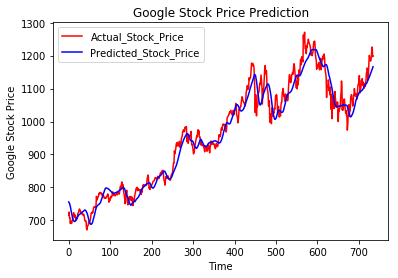

cells: 30
Timesteps: 50
(705, 50, 2)
1
Train on 564 samples, validate on 141 samples
Epoch 1/10
564/564 [==============================] - 5s 9ms/step - loss: 0.0870 - val_loss: 0.0076
Epoch 2/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0150 - val_loss: 0.0087
Epoch 3/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0092 - val_loss: 0.0062
Epoch 4/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 5/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0075 - val_loss: 0.0045
Epoch 6/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0062 - val_loss: 0.0076
Epoch 7/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0063 - val_loss: 0.0050
Epoch 8/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0063 - val_loss: 0.0042
Epoch 9/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 10/10
564

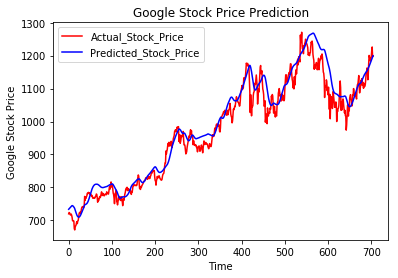

cells: 30
Timesteps: 75
(680, 75, 2)
1
Train on 544 samples, validate on 136 samples
Epoch 1/10
544/544 [==============================] - 6s 10ms/step - loss: 0.1258 - val_loss: 0.0188
Epoch 2/10
544/544 [==============================] - 2s 4ms/step - loss: 0.0203 - val_loss: 0.0047
Epoch 3/10
544/544 [==============================] - 2s 4ms/step - loss: 0.0118 - val_loss: 0.0048
Epoch 4/10
544/544 [==============================] - 2s 4ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 5/10
544/544 [==============================] - 2s 4ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 6/10
544/544 [==============================] - 2s 4ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 7/10
544/544 [==============================] - 2s 4ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 8/10
544/544 [==============================] - 2s 4ms/step - loss: 0.0066 - val_loss: 0.0042
Epoch 9/10
544/544 [==============================] - 2s 4ms/step - loss: 0.0063 - val_loss: 0.0079
Epoch 10/10
54

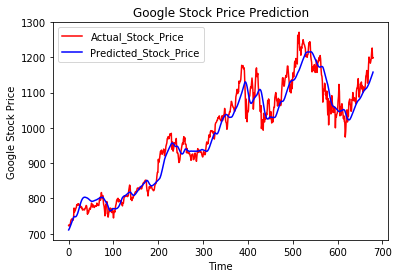

cells: 50
Timesteps: 20
(735, 20, 2)
1
Train on 588 samples, validate on 147 samples
Epoch 1/10
588/588 [==============================] - 5s 8ms/step - loss: 0.1002 - val_loss: 0.0414
Epoch 2/10
588/588 [==============================] - 1s 1ms/step - loss: 0.0146 - val_loss: 0.0066
Epoch 3/10
588/588 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0051
Epoch 4/10
588/588 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 5/10
588/588 [==============================] - 1s 1ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 6/10
588/588 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 7/10
588/588 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 8/10
588/588 [==============================] - 1s 1ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 9/10
588/588 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 10/10
588

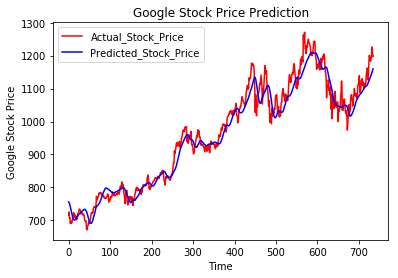

cells: 50
Timesteps: 50
(705, 50, 2)
1
Train on 564 samples, validate on 141 samples
Epoch 1/10
564/564 [==============================] - 7s 13ms/step - loss: 0.0771 - val_loss: 0.0607
Epoch 2/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0159 - val_loss: 0.0086
Epoch 3/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0068 - val_loss: 0.0042
Epoch 4/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0071 - val_loss: 0.0145
Epoch 5/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0082 - val_loss: 0.0113
Epoch 6/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 7/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0057 - val_loss: 0.0035
Epoch 8/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 9/10
564/564 [==============================] - 2s 3ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 10/10
56

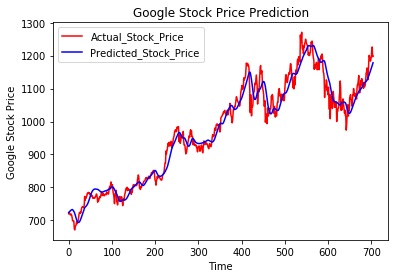

cells: 50
Timesteps: 75
(680, 75, 2)
1
Train on 544 samples, validate on 136 samples
Epoch 1/10
544/544 [==============================] - 7s 13ms/step - loss: 0.0789 - val_loss: 0.0466
Epoch 2/10
544/544 [==============================] - 2s 4ms/step - loss: 0.0156 - val_loss: 0.0057
Epoch 3/10
544/544 [==============================] - 3s 5ms/step - loss: 0.0084 - val_loss: 0.0043
Epoch 4/10
544/544 [==============================] - 2s 5ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 5/10
544/544 [==============================] - 2s 5ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 6/10
544/544 [==============================] - 3s 5ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 7/10
544/544 [==============================] - 2s 5ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 8/10
544/544 [==============================] - 3s 5ms/step - loss: 0.0057 - val_loss: 0.0065
Epoch 9/10
544/544 [==============================] - 3s 5ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 10/10
54

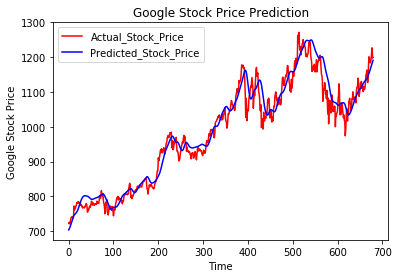

cells: 80
Timesteps: 20
(735, 20, 2)
1
Train on 588 samples, validate on 147 samples
Epoch 1/10
588/588 [==============================] - 7s 11ms/step - loss: 0.0646 - val_loss: 0.0047
Epoch 2/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0111
Epoch 3/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 4/10
588/588 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 5/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 6/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 7/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 8/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 9/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 10/10
58

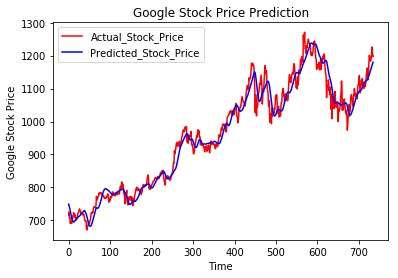

cells: 80
Timesteps: 50
(705, 50, 2)
1
Train on 564 samples, validate on 141 samples
Epoch 1/10
564/564 [==============================] - 10s 18ms/step - loss: 0.0460 - val_loss: 0.0061
Epoch 2/10
564/564 [==============================] - 3s 5ms/step - loss: 0.0091 - val_loss: 0.0066
Epoch 3/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 4/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 5/10
564/564 [==============================] - 3s 5ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 6/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 7/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 8/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 9/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 10/10
5

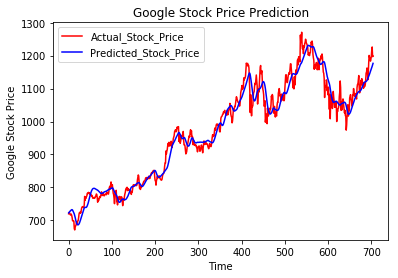

cells: 80
Timesteps: 75
(680, 75, 2)
1
Train on 544 samples, validate on 136 samples
Epoch 1/10
544/544 [==============================] - 12s 21ms/step - loss: 0.0645 - val_loss: 0.0071
Epoch 2/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0129 - val_loss: 0.0041
Epoch 3/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0078 - val_loss: 0.0086
Epoch 4/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 6/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 7/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 8/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 9/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 10/10
5

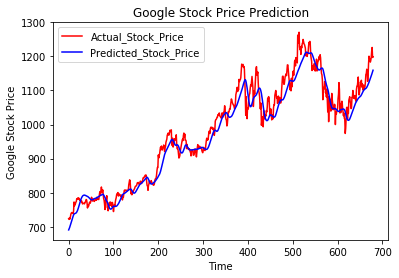

In [15]:
cells = [30,50,80]
tsteps = [20,50,75]
layers =2

for cell in cells :
    for tstep in tsteps:
        print('cells:',cell)
        print('Timesteps:',tstep)
        call_regressor_plot(tstep,cell,layers)

## b). No of hidden layers = 3

cells: 30
Timesteps: 20
(735, 20, 2)
1
Train on 588 samples, validate on 147 samples
Epoch 1/10
588/588 [==============================] - 9s 15ms/step - loss: 0.0973 - val_loss: 0.0148
Epoch 2/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0052
Epoch 3/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0084 - val_loss: 0.0042
Epoch 4/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0043
Epoch 5/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0072 - val_loss: 0.0041
Epoch 6/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0042
Epoch 7/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 8/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 9/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0041
Epoch 10/10
58

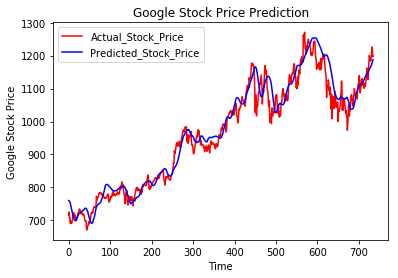

cells: 30
Timesteps: 50
(705, 50, 2)
1
Train on 564 samples, validate on 141 samples
Epoch 1/10
564/564 [==============================] - 10s 18ms/step - loss: 0.1052 - val_loss: 0.0197
Epoch 2/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0243 - val_loss: 0.0052
Epoch 3/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0097 - val_loss: 0.0058
Epoch 4/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0075 - val_loss: 0.0050
Epoch 5/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 6/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 7/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0072 - val_loss: 0.0093
Epoch 8/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 9/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 10/10
5

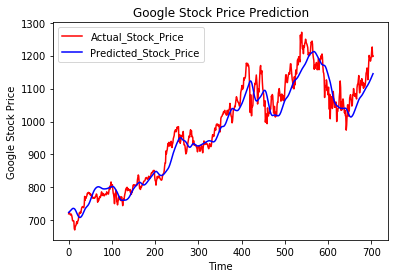

cells: 30
Timesteps: 75
(680, 75, 2)
1
Train on 544 samples, validate on 136 samples
Epoch 1/10
544/544 [==============================] - 12s 22ms/step - loss: 0.1194 - val_loss: 0.0127
Epoch 2/10
544/544 [==============================] - 3s 5ms/step - loss: 0.0252 - val_loss: 0.0081
Epoch 3/10
544/544 [==============================] - 3s 5ms/step - loss: 0.0094 - val_loss: 0.0121
Epoch 4/10
544/544 [==============================] - 3s 5ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 5/10
544/544 [==============================] - 3s 5ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 6/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 7/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 8/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0066 - val_loss: 0.0081
Epoch 9/10
544/544 [==============================] - 3s 5ms/step - loss: 0.0072 - val_loss: 0.0089
Epoch 10/10
5

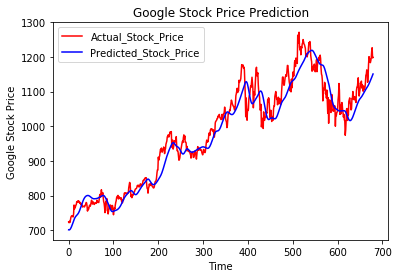

cells: 50
Timesteps: 20
(735, 20, 2)
1
Train on 588 samples, validate on 147 samples
Epoch 1/10
588/588 [==============================] - 11s 19ms/step - loss: 0.0828 - val_loss: 0.0485
Epoch 2/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0111 - val_loss: 0.0069
Epoch 3/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 4/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 5/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0084
Epoch 6/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 7/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 8/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0076
Epoch 9/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 10/10
5

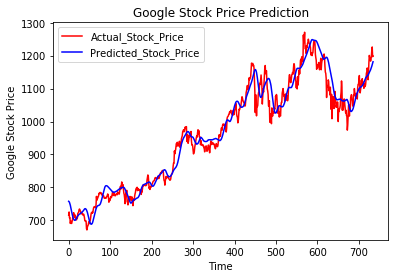

cells: 50
Timesteps: 50
(705, 50, 2)
1
Train on 564 samples, validate on 141 samples
Epoch 1/10
564/564 [==============================] - 13s 22ms/step - loss: 0.0704 - val_loss: 0.0216
Epoch 2/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0111 - val_loss: 0.0085
Epoch 3/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0059 - val_loss: 0.0088
Epoch 4/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 5/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0055 - val_loss: 0.0068
Epoch 6/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0055 - val_loss: 0.0066
Epoch 7/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 8/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 9/10
564/564 [==============================] - 2s 4ms/step - loss: 0.0059 - val_loss: 0.0098
Epoch 10/10
5

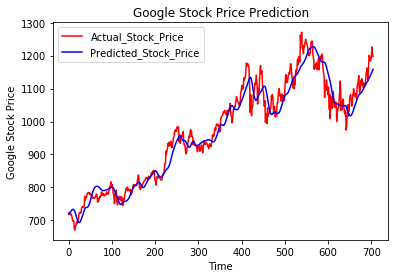

cells: 50
Timesteps: 75
(680, 75, 2)
1
Train on 544 samples, validate on 136 samples
Epoch 1/10
544/544 [==============================] - 14s 27ms/step - loss: 0.0675 - val_loss: 0.0382
Epoch 2/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0126 - val_loss: 0.0057
Epoch 3/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 4/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 5/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 6/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 7/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 8/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 9/10
544/544 [==============================] - 3s 6ms/step - loss: 0.0064 - val_loss: 0.0090
Epoch 10/10
5

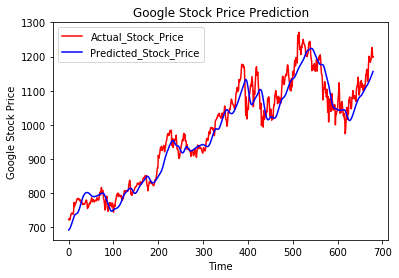

cells: 80
Timesteps: 20
(735, 20, 2)
1
Train on 588 samples, validate on 147 samples
Epoch 1/10
588/588 [==============================] - 13s 22ms/step - loss: 0.0588 - val_loss: 0.0182
Epoch 2/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 3/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0101
Epoch 4/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 5/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 6/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 7/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 8/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 9/10
588/588 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 10/10
5

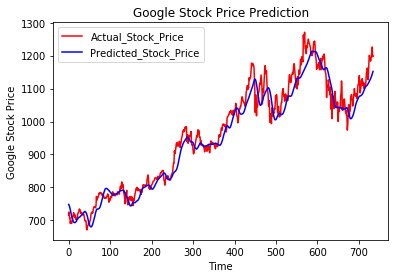

cells: 80
Timesteps: 50
(705, 50, 2)
1
Train on 564 samples, validate on 141 samples
Epoch 1/10
564/564 [==============================] - 15s 27ms/step - loss: 0.0658 - val_loss: 0.0098
Epoch 2/10
564/564 [==============================] - 3s 5ms/step - loss: 0.0122 - val_loss: 0.0199
Epoch 3/10
564/564 [==============================] - 3s 5ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 4/10
564/564 [==============================] - 3s 5ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 5/10
564/564 [==============================] - 3s 5ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 6/10
564/564 [==============================] - 3s 5ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 7/10
564/564 [==============================] - 3s 5ms/step - loss: 0.0048 - val_loss: 0.0089
Epoch 8/10
564/564 [==============================] - 3s 5ms/step - loss: 0.0046 - val_loss: 0.0068
Epoch 9/10
564/564 [==============================] - 3s 5ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 10/10
5

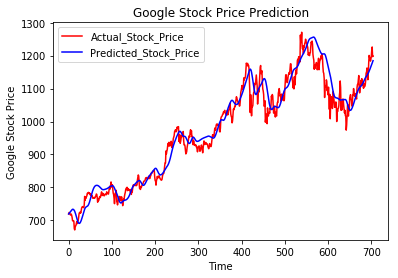

cells: 80
Timesteps: 75
(680, 75, 2)
1
Train on 544 samples, validate on 136 samples
Epoch 1/10
544/544 [==============================] - 18s 33ms/step - loss: 0.0668 - val_loss: 0.0123
Epoch 2/10
544/544 [==============================] - 5s 8ms/step - loss: 0.0123 - val_loss: 0.0116
Epoch 3/10
544/544 [==============================] - 5s 10ms/step - loss: 0.0062 - val_loss: 0.0049
Epoch 4/10
544/544 [==============================] - 5s 10ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 5/10
544/544 [==============================] - 7s 13ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 6/10
544/544 [==============================] - 9s 17ms/step - loss: 0.0055 - val_loss: 0.0060
Epoch 7/10
544/544 [==============================] - 5s 10ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 8/10
544/544 [==============================] - 5s 9ms/step - loss: 0.0043 - val_loss: 0.0056
Epoch 9/10
544/544 [==============================] - 4s 8ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 10

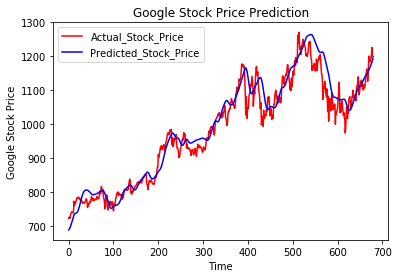

In [16]:
cells = [30,50,80]
tsteps = [20,50,75]
layers = 3

for cell in cells :
    for tstep in tsteps:
        print('cells:',cell)
        print('Timesteps:',tstep)
        call_regressor_plot(tstep,cell,layers)